## Tesla Stock Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense
from keras.layers import LSTM
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

Using TensorFlow backend.
/Users/alfred/Library/Python/3.6/lib/python/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# read csv file
dataframe = pd.read_csv('TSLA.csv')

In [3]:
dataframe.head()

,Time,First,Last
0,08/02/2010 09:00:00.000,20.40,20.74
1,08/02/2010 10:00:00.000,20.74,20.56
2,08/02/2010 11:00:00.000,20.59,20.65
3,08/02/2010 12:00:00.000,20.63,20.67
4,08/02/2010 13:00:00.000,20.68,20.68


### Convert Time into default pandas date time format

In [7]:
dataframe['Time']=pd.to_datetime(dataframe['Time'],infer_datetime_format=True)

In [5]:
dataframe.head()

,Time,First,Last
0,2010-08-02 09:00:00,20.40,20.74
1,2010-08-02 10:00:00,20.74,20.56
2,2010-08-02 11:00:00,20.59,20.65
3,2010-08-02 12:00:00,20.63,20.67
4,2010-08-02 13:00:00,20.68,20.68


### Take Average value of opening and closing stock for smoothness  

In [8]:
dataset = (0.5*(dataframe['First'] + dataframe['Last'])).values

In [7]:
print(dataset)

[ 20.57   20.65   20.62  ... 203.68  204.835 205.4  ]


### Scaling the dataset 

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1)) 

NameError: name 'dataset' is not defined

In [9]:
print(dataset)

[[0.01145074]
 [0.01174768]
 [0.01163632]
 ...
 [0.69110851]
 [0.69539558]
 [0.69749272]]


### Time delay function create time sequence of given delay

In [4]:
def timeDelay(data, delay):
    X_data, y_data = [], []
    #naive version, vectorized version can be implemented,
    #but may run out of memory,
    for i in range(delay, len(data)):
        X_data.append(data[i - (delay):i].tolist())
    X_data = np.array(X_data)
    #print(X_data)
    y_data = data[delay:]
    return np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1)), np.reshape(y_data, (len(y_data),))

### Creating LSTM model

In [5]:
def model():
    model = Sequential()
    model.add(LSTM(4,input_shape=(5, 1), dropout=0.2))
    model.add(Dense(1))
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model

### Define parameters

In [9]:
ratio = 0.8 # Training test ratio
d = 5 # Delay
X, y = timeDelay(dataset, d)
n = int(ratio * len(X))

In [10]:
X_train, y_train = X[:n], y[:n]
X_test, y_test = X[n:], y[n:]

In [11]:
model = model()

Compilation Time :  0.019650936126708984


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=2)

Epoch 1/30
 - 2s - loss: 18431.8647
Epoch 2/30
 - 2s - loss: 18261.6460
Epoch 3/30
 - 2s - loss: 18125.3787
Epoch 4/30
 - 1s - loss: 17944.5945
Epoch 5/30
 - 1s - loss: 17761.9379
Epoch 6/30
 - 1s - loss: 17470.0559
Epoch 7/30
 - 1s - loss: 17087.9374
Epoch 8/30
 - 2s - loss: 16907.0606
Epoch 9/30
 - 2s - loss: 16718.8995
Epoch 10/30
 - 2s - loss: 16548.1863
Epoch 11/30
 - 2s - loss: 16357.6090
Epoch 12/30
 - 2s - loss: 16188.3413
Epoch 13/30
 - 2s - loss: 16019.0233
Epoch 14/30
 - 2s - loss: 15840.3993
Epoch 15/30
 - 2s - loss: 15660.9879
Epoch 16/30
 - 2s - loss: 15496.3305
Epoch 17/30
 - 2s - loss: 15335.5016
Epoch 18/30
 - 2s - loss: 15175.7567
Epoch 19/30
 - 2s - loss: 15005.9125
Epoch 20/30
 - 2s - loss: 14852.5262
Epoch 21/30
 - 2s - loss: 14688.3709
Epoch 22/30
 - 2s - loss: 14524.8296
Epoch 23/30
 - 2s - loss: 14391.9527
Epoch 24/30
 - 2s - loss: 14225.5762
Epoch 25/30
 - 2s - loss: 14069.8470
Epoch 26/30
 - 2s - loss: 13937.5241
Epoch 27/30
 - 2s - loss: 13781.0331
Epoch 28/3

In [17]:
baseline_testScore = scaler.inverse_transform(np.array([[mean_squared_error(y_test[10:], y_test[:-10])**.5]]))
trainScore = scaler.inverse_transform(np.array([[model.evaluate(X_train, y_train, verbose=0)**.5]]))
testScore = scaler.inverse_transform(np.array([[model.evaluate(X_test, y_test, verbose=0)**.5]]))

print('baseline test score = %.2f RMSE' % baseline_testScore)
print('train score = %.2f RMSE' % trainScore)
print('test score = %.2f RMSE' % testScore)

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [14]:
# generate predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [15]:
y = np.append(y_train, y_test)

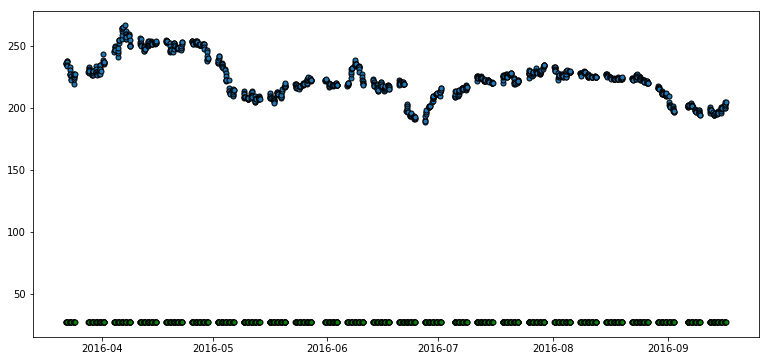

In [16]:
nn = 1000
plt.figure(figsize=(13, 6))
plt.plot(dataframe['Time'][3:][-nn:], np.append(y_train, y_test)[-nn:], 'o', ms=5,markeredgecolor='k')
#plt.plot(dataframe['Time'][3:][:n], y_train_pred, 'r')
plt.plot(dataframe['Time'][3:][n:][-nn:], y_test_pred[-nn:], 'o', ms=5, color='green',markeredgecolor='k')